# Part 3 - Rental Price Prediction

### Content  
- [Section 1 - Data Pre-processing](#section-1)  
- [Section 2 - Modeling - Multi-Linear Regression](#section-2)  
- [Section 3 - Modeling - Random Forest Regressor](#section-3)  
- [Section 4 - Modeling - XGBoost Regressor](#section-4)  
- [Section 5 - Modeling - LightGBM Regressor](#section-5)  
- [Section 6 - Modeling - CatBoost Regressor](#section-6)  
- [Section 7 - Compare Models](#section-7)

#### Links
- https://www.kaggle.com/lizexi/singapore-s-public-housing-eda-price-predictions/report
- https://www.kaggle.com/vikrishnan/house-sales-price-using-regression/notebook#Standardize-the-dataset
- https://www.kaggle.com/prasadperera/the-boston-housing-dataset
- https://www.kaggle.com/vaishnavikhilari/boston-house-price-prediction
- https://medium.com/analytics-vidhya/boston-house-price-prediction-using-machine-learning-ad3750a866cd
- https://towardsdatascience.com/machine-learning-project-predicting-boston-house-prices-with-regression-b4e47493633d
- https://www.ritchieng.com/machine-learning-project-boston-home-prices/
- https://github.com/topics/boston-housing-price-prediction
- https://levelup.gitconnected.com/expensive-cheap-housing-prices-predict-prices-boston-housing-dataset-d60987b65c75
- https://github.com/rahulpatraiitkgp/Predicting-Boston-Housing-Prices
- https://sajalsharma.com/portfolio/boston_housing

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb
import lightgbm as lgb
from catboost import Pool, CatBoostRegressor

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [3]:
import warnings
warnings.filterwarnings("ignore")

___
<a name="section-1"></a>
## (i) Data Pre-Processing

In [4]:
condo_df = pd.read_csv('./Data/condo_dataset_preprocessed.csv')

#### Drop unnecessary columns

In [5]:
condo_df.columns

Index(['amenities', 'beds', 'developer', 'district', 'electoral_div', 'lease',
       'name', 'nearest_mrt_name', 'neighbourhood', 'property_type', 'rental',
       'sqft', 'tenure', 'travel_time_changi', 'travel_time_orchard',
       'travel_time_raffles', 'furnishing', 'amenities_count',
       'nearest_mrt_dist_min', 'nearest_mrt_dist_metres', 'freehold_status',
       'rental_log'],
      dtype='object')

In [6]:
cols_to_drop = ['name','beds','developer','electoral_div','neighbourhood','rental','nearest_mrt_name','property_type',
               'amenities_count','nearest_mrt_dist_min','nearest_mrt_dist_metres','furnishing','tenure','freehold_status']

In [7]:
condo_df_sm = condo_df.drop(columns = cols_to_drop)
condo_df_sm.head()

,amenities,district,lease,sqft,travel_time_changi,travel_time_orchard,travel_time_raffles,rental_log
0,"'Clubhouse', 'Gym', 'Spa Pool', 'Swimming Pool...",D09,Flexible,2100,53,12,16,9.159047
1,"'Aircon', 'Gym', 'Swimming Pool', 'Wading Pool...",D09,Flexible,1399,56,12,13,8.853665
2,"'Bathtub', 'Aircon', 'Maid Room', 'Gym', 'Park...",D05,greater_than_or_equal_24m,1948,70,27,22,8.732305
3,"'Jogging Track', 'Multi-purpose Hall', 'Hammoc...",D22,Flexible,775,85,46,39,7.937375
4,"'Security', 'Jacuzzi', 'Lap Pool', 'Tennis Cou...",D15,Flexible,635,46,41,34,7.783224


#### Generate amenities of interest

In [8]:
list_of_amenities = []
for i in condo_df_sm['amenities']:
    for j in i.split(', '):
        list_of_amenities.append(j)
list_of_amenities = [x.replace("'","") for x in list_of_amenities]

In [9]:
# Value counts of amenities
amenities_df = pd.DataFrame.from_dict(Counter(list_of_amenities), orient='index').reset_index()
amenities_df.rename(columns={'index':'amenities', 0:'count'}, inplace = True)
amenities_df['percentage'] = round(100 * (amenities_df['count'] / condo_df_sm['rental_log'].describe()[0]),1)
amenities_df.sort_values(['count'], ascending = False).set_index('amenities')

,count,percentage
amenities,,
Gym,5661,77.4
Security,5419,74.1
Parking,5187,70.9
BBQ,4944,67.6
Swimming Pool,4590,62.8
Playground,4165,57.0
Jacuzzi,3663,50.1
Aircon,3580,49.0
Clubhouse,3483,47.6


In [10]:
# Identify the amenities that will likely impact rental price (based on own assumptions and business understanding)
key_amenities = ['Balcony','High Floor','Renovated','City View','Greenery View','Steam Room','Sauna']

In [11]:
# Create one-hot encoded column for each amenity
condo_df_with_amenities = condo_df_sm.copy()

for amenity in key_amenities:
    amenity_name = amenity.lower().replace(' ','_')
    condo_df_sm[f'{amenity_name}'] = condo_df_sm['amenities'].str.contains(f'{amenity}')*1 # Multiply by 1 to convert boolean into integer

In [12]:
# Drop original amenities column
condo_df_sm.drop(columns = ['amenities'], inplace = True)

In [13]:
condo_df_sm.sample(10)

,district,lease,sqft,travel_time_changi,travel_time_orchard,travel_time_raffles,rental_log,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna
4209,D04,greater_than_or_equal_24m,829,62,24,17,8.160518,0,0,0,0,1,0,0
3522,D14,Flexible,775,51,33,25,7.696213,0,0,0,0,0,0,0
822,D10,Flexible,560,63,15,23,7.937375,0,0,0,0,0,0,0
6964,D09,greater_than_or_equal_24m,840,53,17,17,8.366370,0,0,0,0,0,0,0
7111,D17,Flexible,1800,35,55,50,8.160518,0,0,0,0,0,0,0
6339,D15,Flexible,1087,34,40,33,8.342840,0,0,0,0,0,0,0
7128,D11,Flexible,1216,54,11,16,8.496990,1,0,0,1,0,0,0
4180,D04,Flexible,3122,69,31,24,9.425452,1,0,0,0,0,1,0
124,D09,greater_than_or_equal_24m,1507,56,11,17,8.853665,0,0,0,0,0,0,0
263,D02,Flexible,560,57,21,9,8.006701,0,0,1,0,0,1,1


___
<a name="section-2"></a>
## (ii) Modeling - Multi-Linear Regression

In [14]:
# Generate dummy columns (while dropping first dummy col to prevent collinearity)
condo_df_lr = condo_df_sm.copy()
condo_df_lr = pd.get_dummies(condo_df_lr, columns = ['district'], drop_first = True)
condo_df_lr = pd.get_dummies(condo_df_lr, columns = ['lease'], drop_first = True)

In [15]:
condo_df_lr.head()

,sqft,travel_time_changi,travel_time_orchard,travel_time_raffles,rental_log,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna,district_D02,district_D03,district_D04,district_D05,district_D06,district_D07,district_D08,district_D09,district_D10,district_D11,district_D12,district_D13,district_D14,district_D15,district_D16,district_D17,district_D18,district_D19,district_D20,district_D21,district_D22,district_D23,district_D25,district_D26,district_D27,district_D28,lease_greater_than_or_equal_24m,lease_less_than_24m
0,2100,53,12,16,9.159047,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,1399,56,12,13,8.853665,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,1948,70,27,22,8.732305,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,775,85,46,39,7.937375,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
4,635,46,41,34,7.783224,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [16]:
# Separate dependent(target) variable and independent variables
X = condo_df_lr.drop(['rental_log'], axis = 1)
y = condo_df_lr['rental_log']

In [17]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [18]:
linear_reg = LinearRegression()
linear_reg.fit(X_train, y_train)

LinearRegression()

In [19]:
# Intercept
linear_reg.intercept_

8.066741777752929

In [20]:
# Display coefficients
coeff = pd.DataFrame([X_train.columns, linear_reg.coef_]).T
coeff = coeff.rename(columns={0: 'Feature', 1: 'Coefficients'})
coeff.sort_values(by='Coefficients', ascending = False)

,Feature,Coefficients
13,district_D04,0.193143
9,steam_room,0.0398002
14,district_D05,0.0369696
5,high_floor,0.0314896
37,lease_greater_than_or_equal_24m,0.0210057
4,balcony,0.0184612
24,district_D15,0.00629312
7,city_view,0.00615152
11,district_D02,0.00267466
1,travel_time_changi,0.00162883


#### Evaluate model on training set

In [21]:
y_pred_train = linear_reg.predict(X_train)

In [22]:
# Model evaluation
print('R^2',metrics.r2_score(y_train, y_pred_train))
print('Adjusted R^2',1 - (1-metrics.r2_score(y_train, y_pred_train))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE',metrics.mean_absolute_error(y_train, y_pred_train))
print('MSE',metrics.mean_squared_error(y_train, y_pred_train))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))

R^2 0.8163375754955555
Adjusted R^2 0.8151047296167822
MAE 0.1748352032737472
MSE 0.05516891834978431
RMSE 0.2348806470311769


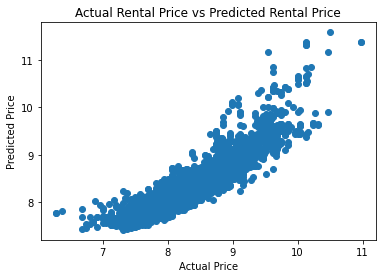

In [23]:
# Visualizing actual prices vs predicted values
plt.scatter(y_train, y_pred_train)
plt.xlabel("Actual Price")
plt.ylabel("Predicted Price")
plt.title("Actual Rental Price vs Predicted Rental Price")
plt.show()

### Performing the 3 checks for multi-linear regression assumptions

#### (1) Equal Error Variance

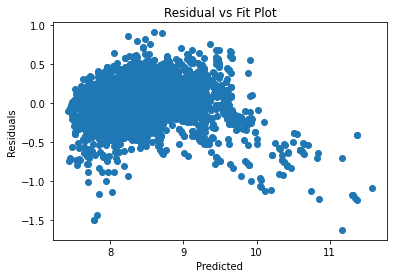

In [24]:
# Residual vs fit plot
plt.scatter(y_pred_train, y_train - y_pred_train)
plt.title("Residual vs Fit Plot")
plt.xlabel("Predicted")
plt.ylabel("Residuals")
plt.show()

Homoscedasticity check passable given no clear distinct pattern in the residual vs fit plot

#### (2) Normal Error

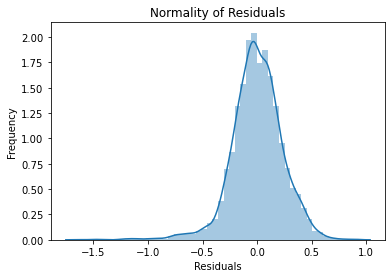

In [25]:
# Normality of residuals
sns.distplot(y_train-y_pred_train)
plt.title("Normality of Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.show()

The residuals are normally distributed, thus the normality assumption is satisfied

#### (3) Independent Error

In [26]:
X_train.columns

Index(['sqft', 'travel_time_changi', 'travel_time_orchard',
       'travel_time_raffles', 'balcony', 'high_floor', 'renovated',
       'city_view', 'greenery_view', 'steam_room', 'sauna', 'district_D02',
       'district_D03', 'district_D04', 'district_D05', 'district_D06',
       'district_D07', 'district_D08', 'district_D09', 'district_D10',
       'district_D11', 'district_D12', 'district_D13', 'district_D14',
       'district_D15', 'district_D16', 'district_D17', 'district_D18',
       'district_D19', 'district_D20', 'district_D21', 'district_D22',
       'district_D23', 'district_D25', 'district_D26', 'district_D27',
       'district_D28', 'lease_greater_than_or_equal_24m',
       'lease_less_than_24m'],
      dtype='object')

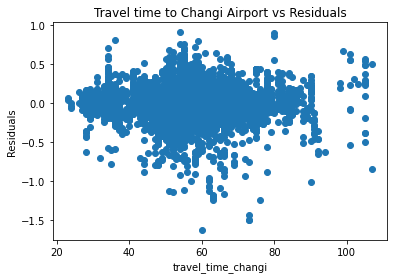

In [27]:
# Independence of X variables
plt.scatter(X_train['travel_time_changi'], y_train-y_pred_train)
plt.title("Travel time to Changi Airport vs Residuals")
plt.xlabel("travel_time_changi")
plt.ylabel("Residuals")
plt.show()

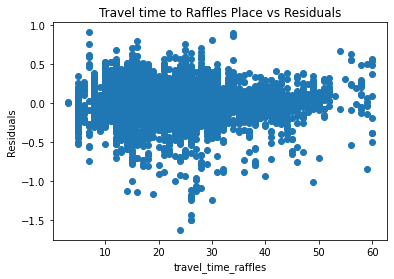

In [28]:
plt.scatter(X_train['travel_time_raffles'], y_train-y_pred_train)
plt.title("Travel time to Raffles Place vs Residuals")
plt.xlabel("travel_time_raffles")
plt.ylabel("Residuals")
plt.show()

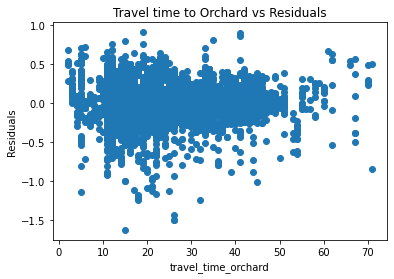

In [29]:
plt.scatter(X_train['travel_time_orchard'], y_train-y_pred_train)
plt.title("Travel time to Orchard vs Residuals")
plt.xlabel("travel_time_orchard")
plt.ylabel("Residuals")
plt.show()

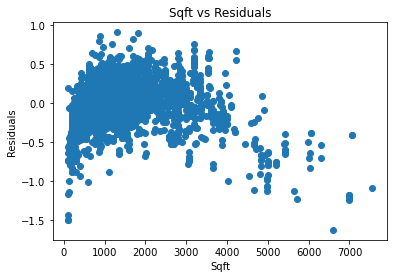

In [30]:
plt.scatter(X_train['sqft'], y_train-y_pred_train)
plt.title("Sqft vs Residuals")
plt.xlabel("Sqft")
plt.ylabel("Residuals")
plt.show()

The above sqft vs residuals plot seems to suggest some form of non-linearity

In [31]:
# Add sqft^2 to deal with above non-linear band pattern
X_train_2 = X_train.copy()
X_train_2['sqft_squared'] = X_train_2['sqft'].apply(lambda x: x**2)
X_train_2.head()

,sqft,travel_time_changi,travel_time_orchard,travel_time_raffles,balcony,high_floor,renovated,city_view,greenery_view,steam_room,sauna,district_D02,district_D03,district_D04,district_D05,district_D06,district_D07,district_D08,district_D09,district_D10,district_D11,district_D12,district_D13,district_D14,district_D15,district_D16,district_D17,district_D18,district_D19,district_D20,district_D21,district_D22,district_D23,district_D25,district_D26,district_D27,district_D28,lease_greater_than_or_equal_24m,lease_less_than_24m,sqft_squared
565,829,62,24,17,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,687241
1883,818,43,27,19,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,669124
2458,721,50,20,12,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,519841
640,990,76,36,31,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,980100
3396,1302,70,27,22,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1695204


In [32]:
linear_reg.fit(X_train_2, y_train)
y_pred_train_2 = linear_reg.predict(X_train_2)

In [33]:
# Model evaluation
print('R^2',metrics.r2_score(y_train, y_pred_train_2))
print('Adjusted R^2',1 - (1-metrics.r2_score(y_train, y_pred_train_2))*(len(y_train)-1)/(len(y_train)-X_train.shape[1]-1))
print('MAE',metrics.mean_absolute_error(y_train, y_pred_train_2))
print('MSE',metrics.mean_squared_error(y_train, y_pred_train_2))
print('RMSE',np.sqrt(metrics.mean_squared_error(y_train, y_pred_train_2)))

R^2 0.8625615285036236
Adjusted R^2 0.8616389638928905
MAE 0.150699124080979
MSE 0.04128406685559826
RMSE 0.2031848096083914


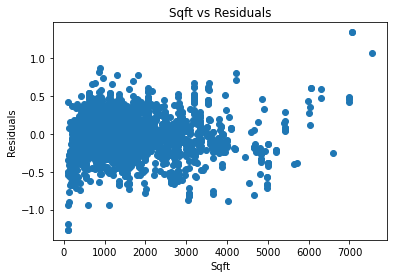

In [34]:
plt.scatter(X_train_2['sqft'], y_train-y_pred_train_2)
plt.title("Sqft vs Residuals")
plt.xlabel("Sqft")
plt.ylabel("Residuals")
plt.show()

The non-linear band seen earlier implies that adjacent error terms were correlated, and thus did not pass the independence test. After adding in the sqft^2 term into the model, the issue has been resolved and the independence assumption is satisfied. 

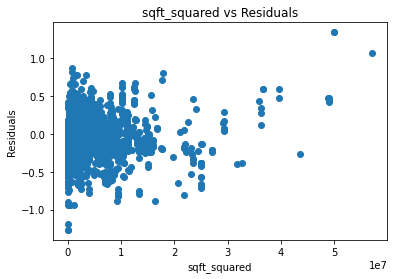

In [35]:
plt.scatter(X_train_2['sqft_squared'], y_train-y_pred_train_2)
plt.title("sqft_squared vs Residuals")
plt.xlabel("sqft_squared")
plt.ylabel("Residuals")
plt.show()

In [36]:
# Display coefficients
linear_reg_features = pd.DataFrame([X_train_2.columns, linear_reg.coef_]).T
linear_reg_features = linear_reg_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
linear_reg_features.sort_values(by='Importance Score', ascending = False)

,Feature,Importance Score
13,district_D04,0.127375
15,district_D06,0.0885135
9,steam_room,0.0306111
4,balcony,0.0277801
5,high_floor,0.0207427
11,district_D02,0.0183861
7,city_view,0.0145485
37,lease_greater_than_or_equal_24m,0.00201898
1,travel_time_changi,0.00108844
0,sqft,0.000869909


#### Evaluation on test set

In [37]:
# Transform test set
X_test['sqft_squared'] = X_test['sqft'].apply(lambda x: x**2)

In [38]:
y_pred_test = linear_reg.predict(X_test)

In [39]:
# Store results as dataframe
lr_dict = {'Model':'Linear Regression',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

In [40]:
linear_reg_metrics = pd.DataFrame.from_dict(lr_dict, orient = 'index').T
linear_reg_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,Linear Regression,0.845383,0.841033,0.153652,0.0442911,0.210455


___
<a name="section-3"></a>
## (iii) Modeling - Random Forest Regressor

In [41]:
condo_df = condo_df_sm.copy()
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) # Not dropping first col
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) # Not dropping first col

In [42]:
# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

In [43]:
# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [44]:
# Create the grid
param_grid = {
        'min_samples_leaf': [1,2,3],
        'min_samples_split': [8, 10, 12],
        'n_estimators': [100, 300, 600]
}

In [45]:
rf_reg = RandomForestRegressor(random_state = 42)

In [46]:
rf_grid = GridSearchCV(estimator = rf_reg, param_grid = param_grid, cv=5, n_jobs=-1, verbose=2)

In [47]:
# Fit the random search model
rf_grid.fit(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.7s
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [8, 10, 12],
                         'n_estimators': [100, 300, 600]},
             verbose=2)

In [48]:
rf_grid.best_params_

{'min_samples_leaf': 1, 'min_samples_split': 8, 'n_estimators': 300}

In [49]:
# Get best RF estimator based on best parameters
rf_best = rf_grid.best_estimator_

# Use RF regressor to predict on test set
y_pred_test = rf_best.predict(X_test)

In [50]:
# Store results as dataframe
rf_dict = {'Model':'Random Forest Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

rf_reg_metrics = pd.DataFrame.from_dict(rf_dict, orient = 'index').T
rf_reg_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,Random Forest Regressor,0.925711,0.923567,0.0882945,0.0212806,0.145879


#### Feature Importance

In [51]:
rf_best.feature_importances_

array([8.38099413e-01, 2.62679373e-02, 3.52611624e-02, 7.16546395e-02,
       8.41319632e-04, 7.79823911e-04, 5.86366475e-04, 6.03209479e-04,
       4.82509646e-04, 2.63818698e-03, 3.15947912e-03, 7.01822029e-04,
       6.81373228e-04, 5.12166487e-04, 2.62732882e-03, 7.09598051e-04,
       1.92155099e-04, 5.95106173e-04, 5.68579148e-04, 2.69372043e-03,
       1.62003804e-03, 9.28885129e-04, 1.11231392e-03, 6.02579302e-05,
       7.73261968e-04, 9.73027014e-04, 1.68607946e-04, 1.70775708e-05,
       5.00396388e-05, 1.66240954e-04, 6.67892070e-04, 7.72106075e-04,
       3.21451057e-04, 1.61438061e-04, 6.99124116e-04, 6.85764895e-06,
       6.01039352e-05, 4.07468027e-05, 4.70576884e-04, 6.06049794e-04,
       6.68006452e-04])

In [52]:
rf_features = pd.DataFrame([X_train.columns, rf_best.feature_importances_]).T
rf_features = rf_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
rf_features.sort_values(by = 'Importance Score', ascending = False)

,Feature,Importance Score
0,sqft,0.838099
3,travel_time_raffles,0.0716546
2,travel_time_orchard,0.0352612
1,travel_time_changi,0.0262679
10,sauna,0.00315948
19,district_D09,0.00269372
9,steam_room,0.00263819
14,district_D04,0.00262733
20,district_D10,0.00162004
22,district_D12,0.00111231


___
<a name="section-4"></a>
## (iv) Modeling - XGBoost Regressor

In [53]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
xgb_param_grid = {'colsample_bytree': [0.4,0.5,0.6,0.7,0.8],
                  'learning_rate' : [0.01,0.1,0.3],
                  'max_depth': [3,4,5,6], 
                  'alpha': [1e-5, 1e-2, 0.1, 1, 100], 
                  'n_estimators':[200]
}

In [55]:
xgb_reg = xgb.XGBRegressor(seed = 42, objective ='reg:squarederror')

xgb_reg_grid = GridSearchCV(estimator = xgb_reg, param_grid = xgb_param_grid, cv=5, n_jobs=-1, verbose=1) 

xgb_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 1500 out of 1500 | elapsed:  5.2min finished


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, gamma=None,
                                    gpu_id=None, importance_type='gain',
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n_estimators=100, n_jobs=...
                                    num_parallel_tree=None, random_state=None,
                                    reg_alpha=None, reg_lambda=None,
                                    scale_pos_weight=None, seed=42,
                                    subsample=None, tree_method=None,
      

In [56]:
xgb_reg_grid.best_params_

{'alpha': 0.1,
 'colsample_bytree': 0.8,
 'learning_rate': 0.3,
 'max_depth': 6,
 'n_estimators': 200}

In [57]:
best_xgb_reg = xgb_reg_grid.best_estimator_
y_pred_test = best_xgb_reg.predict(X_test)

In [58]:
# Store results as dataframe
xgb_dict = {'Model':'XGBoost Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

xgb_metrics = pd.DataFrame.from_dict(xgb_dict, orient = 'index').T
xgb_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,XGBoost Regressor,0.938493,0.936719,0.0828353,0.017619,0.132736


#### Feature Importance

In [59]:
xgb_features = pd.DataFrame([X_train.columns, best_xgb_reg.feature_importances_]).T
xgb_features = xgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
xgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

,Feature,Importance Score
0,sqft,0.288429
14,district_D04,0.076668
2,travel_time_orchard,0.0608801
12,district_D02,0.0548884
30,district_D20,0.0454185
34,district_D25,0.0426632
3,travel_time_raffles,0.0414321
20,district_D10,0.0371839
33,district_D23,0.0291573
16,district_D06,0.0232169


___
<a name="section-5"></a>
## (v) Modeling - LightGBM Regressor

In [60]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [61]:
gbm_param_grid = {'boosting_type': ['gbdt'],
                  'objective': ['regression'],
                  'metric': ['rmse'],
                  'max_depth': [4,6,8,9,10,11,12], 
                  'learning_rate': [0.001,0.01,0.05,0.1,0.2]}

In [62]:
light_gbm_reg = lgb.LGBMRegressor(seed = 42, num_iterations = 1000)

light_gbm_grid = GridSearchCV(estimator = light_gbm_reg, param_grid = gbm_param_grid, cv=5, n_jobs=-1, verbose=1) 

light_gbm_grid.fit(X_train, y_train)

Fitting 5 folds for each of 35 candidates, totalling 175 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   43.1s
[Parallel(n_jobs=-1)]: Done 175 out of 175 | elapsed:  2.9min finished


[LightGBM] [Warning] Accuracy may be bad since you didn't set num_leaves and 2^max_depth > num_leaves


GridSearchCV(cv=5, estimator=LGBMRegressor(num_iterations=1000, seed=42),
             n_jobs=-1,
             param_grid={'boosting_type': ['gbdt'],
                         'learning_rate': [0.001, 0.01, 0.05, 0.1, 0.2],
                         'max_depth': [4, 6, 8, 9, 10, 11, 12],
                         'metric': ['rmse'], 'objective': ['regression']},
             verbose=1)

In [63]:
light_gbm_grid.best_params_

{'boosting_type': 'gbdt',
 'learning_rate': 0.1,
 'max_depth': 12,
 'metric': 'rmse',
 'objective': 'regression'}

In [64]:
best_light_gbm = light_gbm_grid.best_estimator_
y_pred_test = best_light_gbm.predict(X_test)

In [65]:
# Store results as dataframe
lgbm_dict = {'Model':'LightGBM Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

lgbm_metrics = pd.DataFrame.from_dict(lgbm_dict, orient = 'index').T
lgbm_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,LightGBM Regressor,0.935645,0.933788,0.0852931,0.018435,0.135776


#### LightGBM Regressor Feature Importance

In [66]:
lgb_features = pd.DataFrame([X_train.columns, best_light_gbm.feature_importances_]).T
lgb_features = lgb_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
lgb_features.sort_values(by = 'Importance Score', ascending = False).head(15)

,Feature,Importance Score
0,sqft,10392
1,travel_time_changi,5034
2,travel_time_orchard,4458
3,travel_time_raffles,4096
9,steam_room,534
10,sauna,513
4,balcony,508
6,renovated,386
5,high_floor,381
7,city_view,349


___
<a name="section-6"></a>
## (vi) Modeling - CatBoost Regressor

In [67]:
condo_df = condo_df_sm.copy()

# One-hot encoding of categorical variables
condo_df = pd.get_dummies(condo_df, columns = ['district'], drop_first = False) 
condo_df = pd.get_dummies(condo_df, columns = ['lease'], drop_first = False) 

# Separate dependent(target) variable and independent variables
X = condo_df.drop(['rental_log'], axis = 1)
y = condo_df['rental_log']

# Perform train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [68]:
# initialize Pool
train_pool = Pool(X_train, y_train)
test_pool = Pool(X_test) 

In [69]:
catboost_param_grid = {'learning_rate': [0.03, 0.1, 0.15],
                        'depth': [4, 6, 8, 10],
                        'l2_leaf_reg': [1, 3, 5]}

In [70]:
# Initiate CatBoost regressor instance
catboost_reg = CatBoostRegressor(random_seed = 42, iterations=80, loss_function='RMSE')

catboost_reg_grid = GridSearchCV(estimator = catboost_reg, param_grid = catboost_param_grid, cv=5, n_jobs=-1, verbose=2) 

catboost_reg_grid.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 180 out of 180 | elapsed:  1.3min finished


0:	learn: 0.4825778	total: 162ms	remaining: 12.8s
1:	learn: 0.4306642	total: 180ms	remaining: 7.01s
2:	learn: 0.3861952	total: 197ms	remaining: 5.06s
3:	learn: 0.3492119	total: 215ms	remaining: 4.08s
4:	learn: 0.3180769	total: 234ms	remaining: 3.51s
5:	learn: 0.2923810	total: 249ms	remaining: 3.07s
6:	learn: 0.2704087	total: 265ms	remaining: 2.76s
7:	learn: 0.2519777	total: 282ms	remaining: 2.54s
8:	learn: 0.2366219	total: 299ms	remaining: 2.36s
9:	learn: 0.2249836	total: 316ms	remaining: 2.21s
10:	learn: 0.2146017	total: 331ms	remaining: 2.07s
11:	learn: 0.2050980	total: 348ms	remaining: 1.97s
12:	learn: 0.1983788	total: 366ms	remaining: 1.89s
13:	learn: 0.1926204	total: 390ms	remaining: 1.84s
14:	learn: 0.1869644	total: 407ms	remaining: 1.76s
15:	learn: 0.1818013	total: 424ms	remaining: 1.7s
16:	learn: 0.1781673	total: 441ms	remaining: 1.63s
17:	learn: 0.1744872	total: 460ms	remaining: 1.58s
18:	learn: 0.1702316	total: 481ms	remaining: 1.54s
19:	learn: 0.1677986	total: 497ms	remainin

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x00000250CBE3F730>,
             n_jobs=-1,
             param_grid={'depth': [4, 6, 8, 10], 'l2_leaf_reg': [1, 3, 5],
                         'learning_rate': [0.03, 0.1, 0.15]},
             verbose=2)

In [71]:
catboost_reg_grid.best_params_

{'depth': 10, 'l2_leaf_reg': 1, 'learning_rate': 0.15}

In [72]:
best_catboost_reg = catboost_reg_grid.best_estimator_

# Make the prediction using the resulting model
y_pred_test = best_catboost_reg.predict(X_test)

In [73]:
# Store results as dataframe
catboost_dict = {'Model':'CatBoost Regressor',
          'R^2':metrics.r2_score(y_test, y_pred_test),
          'Adjusted R^2':(1 - (1-metrics.r2_score(y_test, y_pred_test))*(len(y_test)-1)/(len(y_test)-X_test.shape[1]-1)),
          'MAE':metrics.mean_absolute_error(y_test, y_pred_test),
          'MSE':metrics.mean_squared_error(y_test, y_pred_test),
          'RMSE':np.sqrt(metrics.mean_squared_error(y_test, y_pred_test))}

catboost_metrics = pd.DataFrame.from_dict(catboost_dict, orient = 'index').T
catboost_metrics

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,CatBoost Regressor,0.929586,0.927554,0.0985153,0.0201706,0.142023


#### CatBoost Regressor Feature Importance

In [74]:
catboost_features = pd.DataFrame([X_train.columns, best_catboost_reg.feature_importances_]).T
catboost_features = catboost_features.rename(columns={0: 'Feature', 1: 'Importance Score'})
catboost_features.sort_values(by = 'Importance Score', ascending = False).head(15)

,Feature,Importance Score
0,sqft,55.5845
3,travel_time_raffles,14.3605
2,travel_time_orchard,9.26822
1,travel_time_changi,9.24173
10,sauna,2.12096
19,district_D09,1.95904
9,steam_room,1.60228
14,district_D04,0.955456
20,district_D10,0.734341
24,district_D14,0.382136


___
<a name="section-7"></a>
## (vi) Modeling - Compare Models

In [75]:
df_metrics = pd.concat([linear_reg_metrics, rf_reg_metrics, xgb_metrics, lgbm_metrics, catboost_metrics])

In [76]:
df_metrics.sort_values(by = 'RMSE', ascending = True)

,Model,R^2,Adjusted R^2,MAE,MSE,RMSE
0,XGBoost Regressor,0.938493,0.936719,0.0828353,0.017619,0.132736
0,LightGBM Regressor,0.935645,0.933788,0.0852931,0.018435,0.135776
0,CatBoost Regressor,0.929586,0.927554,0.0985153,0.0201706,0.142023
0,Random Forest Regressor,0.925711,0.923567,0.0882945,0.0212806,0.145879
0,Linear Regression,0.845383,0.841033,0.153652,0.0442911,0.210455


While XGBoost gave the best metrics results, LightGBM's performance was also very close to that of XGBoost. In addition, LightGBM was able to train faster than XGBoost.

In [77]:
lgb_features.sort_values(by='Importance Score', ascending = False).head(10)

,Feature,Importance Score
0,sqft,10392
1,travel_time_changi,5034
2,travel_time_orchard,4458
3,travel_time_raffles,4096
9,steam_room,534
10,sauna,513
4,balcony,508
6,renovated,386
5,high_floor,381
7,city_view,349


In [78]:
xgb_features.sort_values(by='Importance Score', ascending = False).head(10)

,Feature,Importance Score
0,sqft,0.288429
14,district_D04,0.076668
2,travel_time_orchard,0.0608801
12,district_D02,0.0548884
30,district_D20,0.0454185
34,district_D25,0.0426632
3,travel_time_raffles,0.0414321
20,district_D10,0.0371839
33,district_D23,0.0291573
16,district_D06,0.0232169


___
### References
- https://www.qualtrics.com/support/stats-iq/analyses/regression-guides/interpreting-residual-plots-improve-regression/
- https://www.datatechnotes.com/2019/10/accuracy-check-in-python-mae-mse-rmse-r.html
- https://www.kaggle.com/shreayan98c/boston-house-price-prediction
- https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
- https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
- https://catboost.ai/docs/concepts/about.html